In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from remezlp import remezlp
import subprocess

def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)
    
def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I, dtype=complex)
    xI[::I] = x
    return xI

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def plotdB(x, win=False, epsilon=1e-12):
    if win==True:
        w = signal.windows.hamming(len(x), False)
        x *= w
    x += epsilon
    XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))
    XdB -= np.max(XdB)
    freqs = np.arange(len(x))/len(x) - 0.5

    plt.plot(freqs, XdB)
    plt.grid()
    # plt.show();

def plot(x, win=False, epsilon=1e-15):
    if win==True:
        w = signal.hann(len(x), False)
        x *= w
    Xfft = np.abs(np.fft.fftshift(np.fft.fft(x)))
    Xfft /= np.max(Xfft)
    freqs = np.arange(len(x))/len(x) - 0.5
    plt.plot(freqs, Xfft)
    plt.grid()
    

def makePolyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff)/M))
    tmp = np.zeros(n*M)
    tmp[:len(coeff)] = coeff
    polyCoeff = np.zeros((M,n))
    for i in range(M):
        polyCoeff[i,:] = tmp[i::M]
    return polyCoeff

def polyI(x, firCoeff, I):
    polyFIR = makePolyphase(firCoeff, I)
    xPoly = np.zeros(len(x)*I, dtype=x.dtype)
    for i in range(I):
        tmp = signal.lfilter(polyFIR[i], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
        tmp = tmp[int(len(firCoeff)/I-1):]
        xPoly[i::I] = tmp
    return xPoly

def polyD(x, firCoeff, D):
    polyFIR = makePolyphase(firCoeff, I)
    x_ = np.concatenate((x, x[:int(len(firCoeff)-1)]))
    y = []
    for i in range(D):
        FIRin = x_[i::D]
        tmp = signal.lfilter(polyFIR[D-1-i], 1.0, FIRin)
        y = np.append(y, tmp)
    y = np.array(y)
    return y

def fftdB(x, epsilon=1e-12):
    return 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))

def interpolate(x, I, F, delta, show=False, prt=False):
    N = len(x)
    Fpass, Fstop = F[0], F[1]
    deltaPass, deltaStop = delta[0], delta[1]

    Fpass_arr = []
    Fstop_arr = []
    dF = []
    N_fir = []
    firCoeffs = []

    iterator = int(np.log(I)/np.log(2))
    for i in range(iterator):
        Fstop = (1 - Fpass)/2
        Fpass /= 2
        firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
        # print(len(firCoeff))
        x = expander(x, 2)
        x = signal.lfilter(firCoeff, 1.0, np.concatenate((x, x[:len(firCoeff)-1])))[len(firCoeff)-1:]
        # x = polyI(x, firCoeff, 2)

        firCoeffs.append(firCoeff)
        Fpass_arr.append(Fpass)
        Fstop_arr.append(Fstop)
        dF.append(Fstop - Fpass)
        N_fir.append(firCoeff.size)
        if show:
            plotdB(x, win = True)
            plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
            plt.ylim([-150, 10])
            plt.show();
    if prt:
        print(f"Fpass = {Fpass_arr}")
        print(f"Fstop = {Fstop_arr}")
        print(f"dF = {dF}")
        print(f"N_fir = {N_fir}")
        print(firCoeffs)

    return x

def delay(x, firCoeff, I, l):
    polyFIR = makePolyphase(firCoeff, I)
    delayFIR = polyFIR[l]
    delay = int((len(firCoeff) - 1)/I/2)
    y = signal.lfilter(delayFIR, 1.0, x)
    # y = y[delay:]
    return y, delay

def convert_1b(x, LUT):
    y = []
    for i in range(len(x)):
        try:
            pos = int(x[i] + 8)
            tmp = [-1 if val == 0 else 1 for val in LUT[-1 - pos]]
            y = np.concatenate((y, tmp))
        except IndexError:
            print(f"IndexError: pos={pos} is out of bounds for LUT with length {len(LUT)}")
            continue  # Skip the current iteration if an error occurs
    return np.array(y)

def paralelToSerialConverter(x, LUT):
    y = []

    for i in range(len(x)):
        pos = int(x[i] + 8)
        y = np.concatenate((y, LUT[-1-pos]))
    return np.array(y)

def rfiq(a, b):
    z = []
    for i in range(len(a)):
        z.append(a[i])
        z.append(b[i])
        z.append(-a[i])
        z.append(-b[i])
    return np.array(z)

def process_lut(lut):
    """
    Processes a 2D LUT (array of 1s and 0s), summing each row where 1 -> +1 and 0 -> -1.
    
    :param lut: List of lists containing 1s and 0s
    :return: List of row-wise sums
    """
    return np.array([sum(1 if elem == 1 else -1 for elem in row) for row in lut])

LUT1 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 7
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],  # Level 6
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],  # Level 5
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],  # Level 4
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 3
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # Level 2
    [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 1
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 0
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],  # Level -1
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],  # Level -2
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -3
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -4
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -5
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Level -8
]

LUT2 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],  # Level 7
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],  # Level 6
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 5
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 4
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],  # Level 3
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 2
    [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0],  # Level 1
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # Level 0
    [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -1
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],  # Level -2
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -3
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -4
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],  # Level -5
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -6
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # Level -8
]

LUT3 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 8
    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],  # Level 7
    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 6
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 5
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],  # Level 4
    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],  # Level 3
    [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1],  # Level 2
    [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1],  # Level 1
    [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0],  # Level 0
    [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],  # Level -1
    [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],  # Level -2
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],  # Level -3
    [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],  # Level -4
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -5
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -6
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # Level -7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # Level -8    
]

LUT4 = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Level 7.5
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],  # Level 6.5
    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],  # Level 5.5
    [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],  # Level 4.5
    [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],  # Level 3.5
    [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],  # Level 2.5
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # Level 1.5
    [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1],  # Level 0.5
    [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0],  # Level -0.5
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],  # Level -1.5
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],  # Level -2.5
    [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],  # Level -3.5
    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],  # Level -4.5
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # Level -5.5
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Level -6.5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Level -7.5
]

LUT5 = [
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],  # Level 7.5
    [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],  # Level 6.5
    [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],  # Level 5.5
    [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1],  # Level 4.5
    [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1],  # Level 3.5
    [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1],  # Level 2.5
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],  # Level 1.5
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],  # Level 0.5
    [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],  # Level -0.5
    [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],  # Level -1.5
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],  # Level -2.5
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],  # Level -3.5
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],  # Level -4.5
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],  # Level -5.5
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Level -6.5
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]   # Level -7.5 


Fmax = 0.425


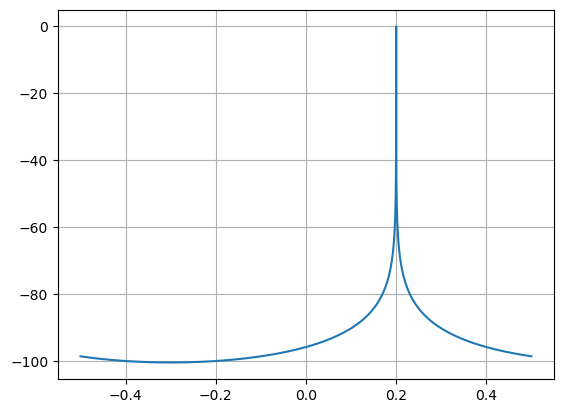

In [3]:
N = 2**16
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

F = [0.0, Fmax]
A = [1e-8, 1.0]
x = 2*genTestSpectrum(N, F, A, True)
amp = 1e-6
x += np.random.normal(-amp, amp, len(x))

x = 1.0 * np.exp(1j * 2*np.pi*0.2*n)
plotdB(x, False)

In [5]:
AdB = 120
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

I = 8
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
x_real_osr8 = interpolate(x.real, I, F, delta, show=False, prt=False)
x_imag_osr8 = interpolate(x.imag, I, F, delta, show=False, prt=False)

In [6]:
AdB = 120
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

I = 4
Fpass = Fmax / I
Fstop = (1 - Fmax) / I
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)
x_real_delayed = signal.lfilter(polyFirCoeff[-2], 1.0, x_real_osr8)
x_imag_delayed = signal.lfilter(polyFirCoeff[-1], 1.0, x_imag_osr8)

m = np.max(x_real_delayed)

x_real_delayed *= 4/m;
x_imag_delayed *= 4/m;
print(np.max(x_real_delayed))

# Save x_real_delayed and x_imag_delayed to text files
real_delayed_path = "./real_osr8.txt"
imag_delayed_path = "./imag_osr8.txt"
np.savetxt(real_delayed_path, x_real_delayed, fmt="%.18e")
np.savetxt(imag_delayed_path, x_imag_delayed, fmt="%.18e")

(4+0j)


In [8]:
# Path to C++ executable
cpp_program_path = "../build/delta-sigma"

real_deltaSigma_path = "./real_deltaSigma.txt"
imag_deltaSigma_path = "./imag_deltaSigma.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

# Call the C++ program with input and output file paths as arguments
subprocess.run([cpp_program_path, real_delayed_path, imag_delayed_path, real_deltaSigma_path, imag_deltaSigma_path, iir_path, "mid-tread"])

x_real_in = np.round(np.loadtxt(real_deltaSigma_path))
x_imag_in = np.round(np.loadtxt(imag_deltaSigma_path))

terminate called after throwing an instance of 'std::runtime_error'
  what():  Malformed real data line: (-1.081493652558525724e-05+0.000000000000000000e+00j)


In [6]:
LUT = LUT2
lut_width = len(LUT[0])

x_real_1b = convert_1b(x_real_in, LUT)
x_imag_1b = convert_1b(x_imag_in, LUT)

In [7]:
x_rfiq = rfiq(x_real_1b, x_imag_1b)

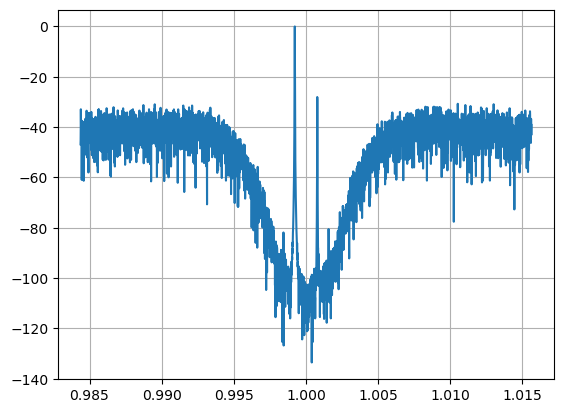

In [8]:
w = signal.windows.hann(len(x_rfiq), False)
x_rfiq *= w

xfftdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_rfiq))) + 1e-12)

xmin = 1 - 0.5/lut_width
xmax = 1 + 0.5/lut_width
imin = int((xmin/4 + 0.5) * len(x_rfiq))
imax = int((xmax/4 + 0.5) * len(x_rfiq))

xfftdB = xfftdB[imin:imax]
xfftdB -= np.max(xfftdB)

freqs = np.linspace(xmin, xmax, len(xfftdB))

plt.plot(freqs, xfftdB)
plt.grid()
plt.show();

In [9]:
def fftdB(x):
    xfftdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x * signal.windows.hann(len(x), False)))) + 1e-15)
    xfftdB -= np.max(xfftdB)
    angle = np.angle(np.fft.fftshift(np.fft.fft(x)))[np.argmax(np.abs(np.fft.fftshift(np.fft.fft(x))))]
    freqs = np.arange(len(x)) / len(x) - 0.5
    return freqs, xfftdB, angle

def rfiq_(x, NyqZones):
    rfi = np.ones(NyqZones)
    rfi[NyqZones//4:NyqZones//2] = 0
    rfi[NyqZones//2:3*NyqZones//4] = -1
    rfi[3*NyqZones//4:] = 0
    
    rfq = np.ones(NyqZones)
    rfq[:NyqZones//4] = 0
    rfq[NyqZones//2:3*NyqZones//4] = 0
    rfq[3*NyqZones//4:] = -1
    
    x_upsampled = np.zeros((len(x)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
    x_upsampled[::NyqZones] = x
    
    x_rfi = np.convolve(rfi, x_upsampled.real)
    x_rfq = np.convolve(rfq, x_upsampled.imag)
    x_rfiq = x_rfi + x_rfq
    return x_rfiq

Fmax = 0.425


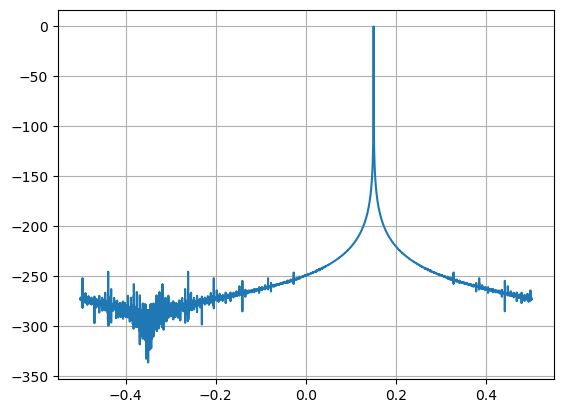

In [10]:
perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

N = 2**16
n = np.arange(N)
Fc = 0.15

x = 1.0 * np.exp(1j * 2*np.pi*Fc*n)
xr = x.real
xi = x.imag

freqs, xfft, angle = fftdB(x)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

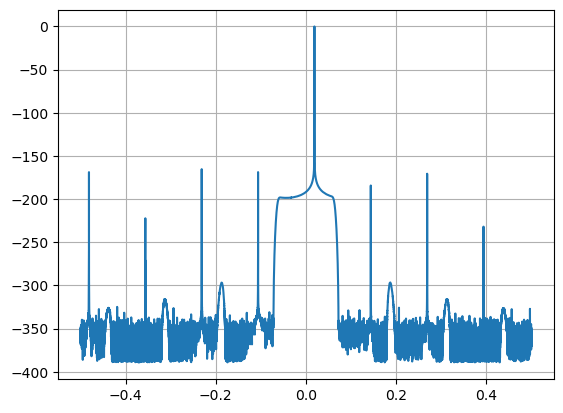

In [11]:
AdB = 160
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

delta = [deltaPass, deltaStop]
F = [Fmax, 1-Fmax]

I = 8

xr_in = xr
xi_in = xi

xr_osr8 = interpolate(xr_in, I, F, delta, show=False, prt=False)
xi_osr8 = interpolate(xi_in, I, F, delta, show=False, prt=False)
x_osr8 = xr_osr8 + 1j*xi_osr8
freqs, xfft, angle = fftdB(x_osr8)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

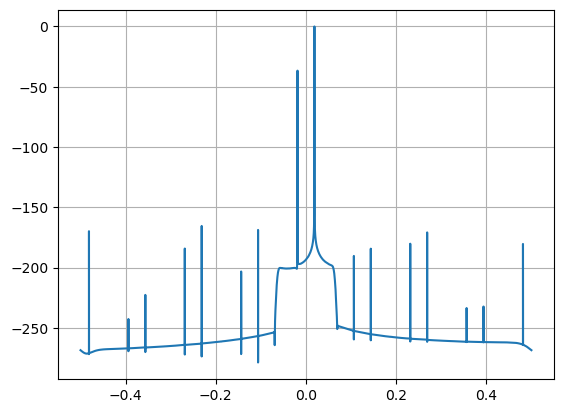

In [12]:
AdB = 140
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

I = 4
Fpass = Fmax / I
Fstop = (1 - Fmax) / I
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)

xr_in = xr_osr8
xi_in = xi_osr8

xr_d = signal.lfilter(polyFirCoeff[-2], 1.0, xr_in)
xi_d = signal.lfilter(polyFirCoeff[-1], 1.0, xi_in)
x_d = xr_d + 1j*xi_d
freqs, xfft, angle = fftdB(x_d)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

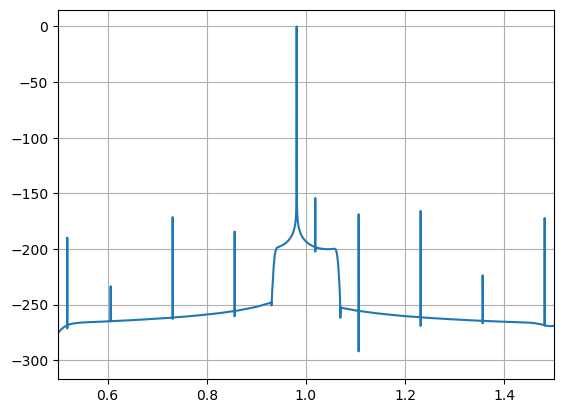

In [13]:
NyqZones = 4

x_in = x_d

x_rfiq = rfiq_(x_in, NyqZones)
freqs, xfft, angle = fftdB(x_rfiq)
freqs *= NyqZones

plt.plot(freqs, xfft)
plt.xlim([1-0.5, 1+0.5])
plt.grid()
plt.show();

Fmax = 0.425


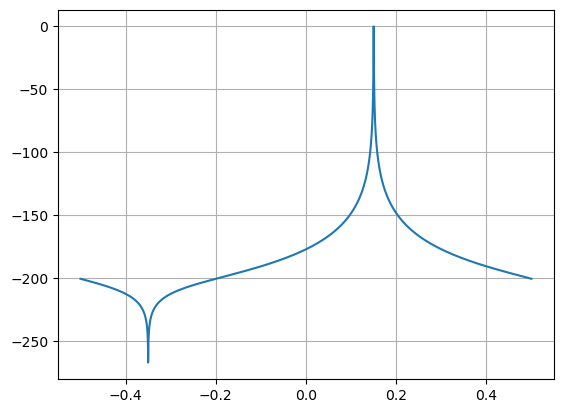

In [14]:
perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

N = 2**12
n = np.arange(N)
Fc = 0.15

x = 1.0 * np.exp(1j * 2*np.pi*Fc*n)
xr = x.real
xi = x.imag

freqs, xfft, angle = fftdB(x)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

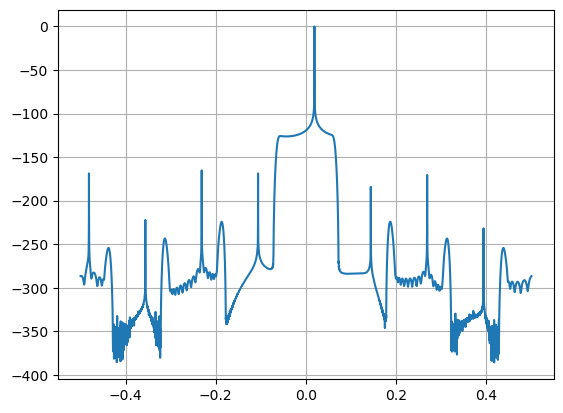

In [15]:
AdB = 160
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

delta = [deltaPass, deltaStop]
F = [Fmax, 1-Fmax]

I = 8

xr_in = xr
xi_in = xi

xr_osr8 = interpolate(xr_in, I, F, delta, show=False, prt=False).real
xi_osr8 = interpolate(xi_in, I, F, delta, show=False, prt=False).real
A = 4
xr_osr8 *= A / np.max(xr_osr8)
xi_osr8 *= A / np.max(xi_osr8)

x_osr8 = xr_osr8 + 1j*xi_osr8
freqs, xfft, angle = fftdB(x_osr8)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

In [16]:
x = 4.0 * np.exp(1j * 2*np.pi*Fc/8*n)
xr_osr8 = x.real
xi_osr8 = x.imag

File written to ./real_deltaSigma.txt
File written to ./imag_deltaSigma.txt


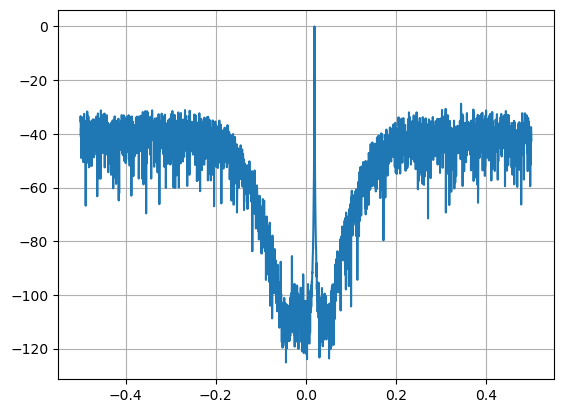

In [17]:
xr_path = "./real_osr8.txt"
xi_path = "./imag_osr8.txt"
np.savetxt(xr_path, xr_osr8, fmt="%.18e")
np.savetxt(xi_path, xi_osr8, fmt="%.18e")

# Path to C++ executable
cpp_program_path = "../build/delta-sigma"

real_deltaSigma_path = "./real_deltaSigma.txt"
imag_deltaSigma_path = "./imag_deltaSigma.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"

# Call the C++ program with input and output file paths as arguments
subprocess.run([cpp_program_path, xr_path, xi_path, real_deltaSigma_path, imag_deltaSigma_path, iir_path])

xr_deltaSigma = np.round(np.loadtxt(real_deltaSigma_path))
xi_deltaSigma = np.round(np.loadtxt(imag_deltaSigma_path))
x_deltaSigma = xr_deltaSigma + 1j*xi_deltaSigma

freqs, xfft, angle = fftdB(x_deltaSigma)
plt.plot(freqs, xfft)
plt.grid()
plt.show();

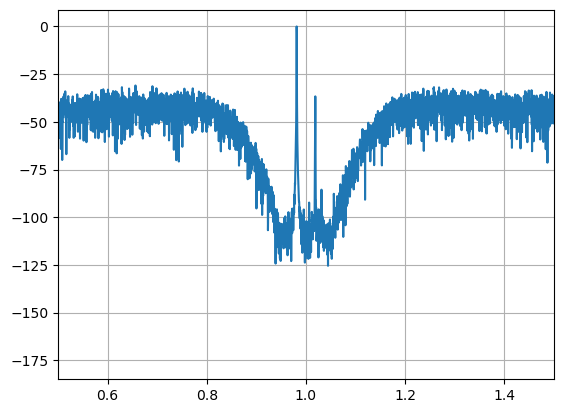

In [18]:
x_deltaSigma_rfiq = rfiq_(x_deltaSigma, 4)
freqs, xfft, angle = fftdB(x_deltaSigma_rfiq)
freqs *= 4

plt.plot(freqs, xfft)
# plt.xlim([xmin, xmax])
plt.xlim([0.5, 1.5])
plt.grid()
plt.show();

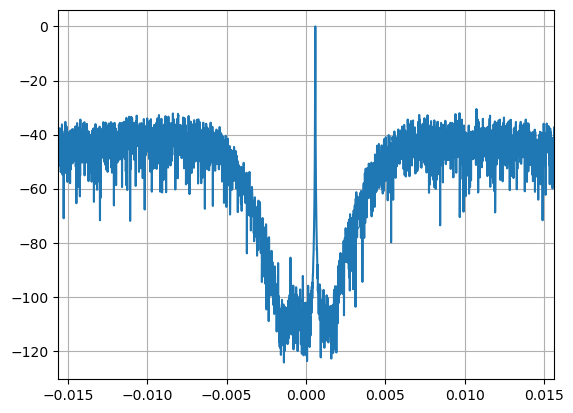

In [19]:
LUT = LUT3

xr_in = xr_deltaSigma
xi_in = xi_deltaSigma

xr_1b = convert_1b(xr_in, LUT)
xi_1b = convert_1b(xi_in, LUT)
x_1b = xr_1b + 1j*xi_1b

freqs, xfft, angle = fftdB(x_1b)
xmin = -0.5/len(LUT[0])
xmax = 0.5/len(LUT[0])

plt.plot(freqs, xfft)
plt.xlim([xmin, xmax])
# plt.xlim([0.5, 1.5])
plt.grid()
plt.show();

In [ ]:
x_rfiq = rfiq(xr_1b, xi_1b)

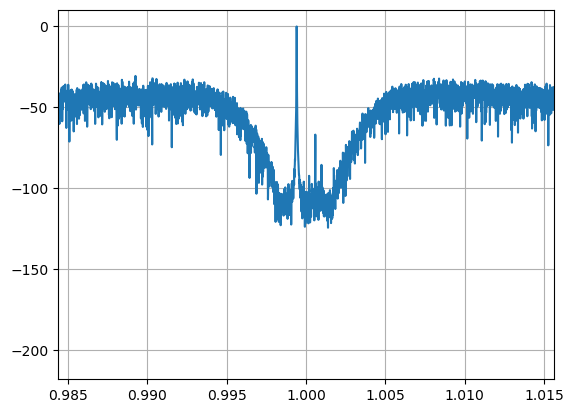

In [147]:
freqs, xfft, angle = fftdB(x_rfiq)
freqs *= 4

xmin = 1 - 0.5/len(LUT[0])
xmax = 1 + 0.5/len(LUT[0])

plt.plot(freqs, xfft)
plt.xlim([xmin, xmax])
# plt.xlim([0.5, 1.5])
plt.grid()
plt.show();

In [15]:
def fftdB(x):
    xfftdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x * signal.windows.hann(len(x), False)))) + 1e-15)
    xfftdB -= np.max(xfftdB)
    angle = np.angle(np.fft.fftshift(np.fft.fft(x)))[np.argmax(np.abs(np.fft.fftshift(np.fft.fft(x))))]
    freqs = np.arange(len(x)) / len(x) - 0.5
    return freqs, xfftdB, angle

def rfiq_(x, NyqZones):
    rfi = np.ones(NyqZones)
    rfi[NyqZones//4:NyqZones//2] = 0
    rfi[NyqZones//2:3*NyqZones//4] = -1
    rfi[3*NyqZones//4:] = 0
    
    rfq = np.ones(NyqZones)
    rfq[:NyqZones//4] = 0
    rfq[NyqZones//2:3*NyqZones//4] = 0
    rfq[3*NyqZones//4:] = -1
    
    x_upsampled = np.zeros((len(x)-1)*NyqZones+1, dtype = complex) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + (M-1) = N*M as it should be!
    x_upsampled[::NyqZones] = x
    
    x_rfi = np.convolve(rfi, x_upsampled.real)
    x_rfq = np.convolve(rfq, x_upsampled.imag)
    x_rfiq = x_rfi + x_rfq
    return x_rfiq

In [16]:
N = 2**16
F = 0.2

perc = 0.15
Fmax = 0.5 * (1 - perc)

x = 1.0 * np.exp(1j * 2*np.pi* F * np.arange(N))

In [17]:
AdB = 20
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

I = 4
Fpass = Fmax / I
Fstop = (1 - Fmax) / I
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff) - 1) / I / 2)
xr_delayed = signal.lfilter(polyFirCoeff[-2], 1.0, x.real)
xi_delayed = signal.lfilter(polyFirCoeff[-1], 1.0, x.imag)

In [18]:
AdB = 120
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

I = 8
F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

# Interpolation by a factor of 8
xr_osr8 = interpolate(xr_delayed, I, F, delta, show=False, prt=False)
xi_osr8 = interpolate(xi_delayed, I, F, delta, show=False, prt=False)

In [135]:
# x_ = xr_delayed + 1j*xi_delayed
x_ = xr_osr8 + 1j*xi_osr8
x_rfiq = rfiq_(x_, 4)
freqs, xfft, angle = fftdB(x_rfiq)
freqs*= 4

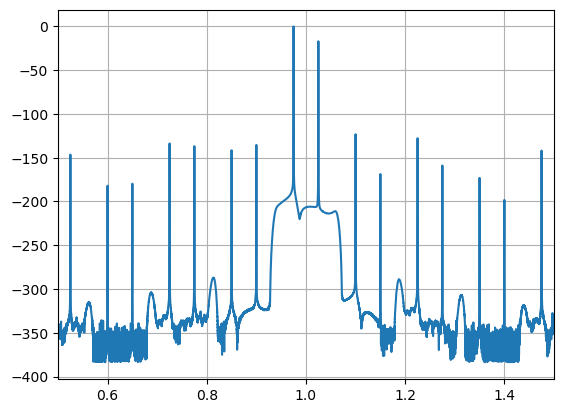

In [136]:
plt.plot(freqs, xfft)
plt.xlim([1-0.5, 1+0.5])
plt.grid()
plt.show();

In [80]:
def fftdB(x):
    xfftdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x * signal.windows.hann(len(x), False)))) + 1e-15)
    xfftdB -= np.max(xfftdB)
    angle = np.angle(np.fft.fftshift(np.fft.fft(x)))[np.argmax(np.abs(np.fft.fftshift(np.fft.fft(x))))]
    freqs = np.arange(len(x)) / len(x) - 0.5
    return freqs, xfftdB, angle

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

AdB = 120
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

F = [Fmax, 1-Fmax]
delta = [deltaPass, deltaStop]

Fmax = 0.425


In [62]:
LUTs = [LUT1, LUT2, LUT3, LUT4, LUT5]
for LUT in LUTs:
    print(process_lut(LUT)/2)
    print("\n")

[ 8.  7.  6.  5.  4.  3.  2.  1.  0. -1. -2. -3. -4. -5. -6. -7. -8.]


[ 16.  14.  12.  10.   8.   6.   4.   2.   0.  -2.  -4.  -6.  -8. -10.
 -12. -14. -16.]


[ 16.  14.  12.  10.   8.   6.   4.   2.   0.  -2.  -4.  -6.  -8. -10.
 -12. -14. -16.]


[ 7.5  6.5  5.5  4.5  3.5  2.5  1.5  0.5 -0.5 -1.5 -2.5 -3.5 -4.5 -5.5
 -6.5 -7.5]


[ 7.5  6.5  5.5  4.5  3.5  2.5  1.5  0.5 -0.5 -1.5 -2.5 -3.5 -4.5 -5.5
 -6.5 -7.5]




In [81]:
N = 2**16
x = 8.0*np.sin(2*np.pi*0.02*np.arange(N))
x = np.round(x)

LUT = LUT3
x_1b = convert_1b(x, LUT)

In [82]:
freqs, xfft, angle = fftdB(x)
freqs_1b, xfft_1b, angle_1b = fftdB(x_1b)

In [84]:
# print(angle[np.argmax(xfft)]/np.pi)
# plt.plot(freqs, angle/np.pi)
# plt.show();

# print(angle_1b[np.argmax(xfft_1b)]/np.pi)
# plt.plot(freqs_1b, angle_1b/np.pi)
# plt.show();

In [76]:
print(LUT)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1], [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1], [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1], [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 0, 

2.4503270363822973
2.5112083970401025


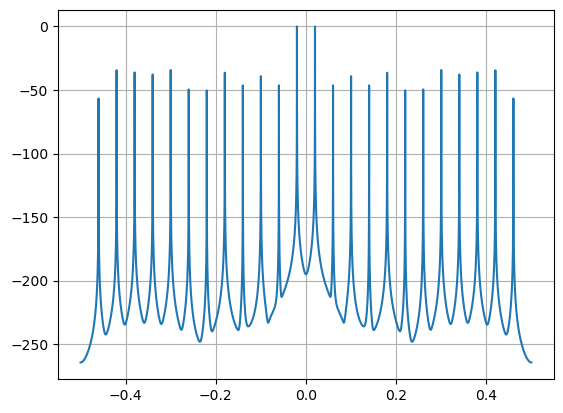

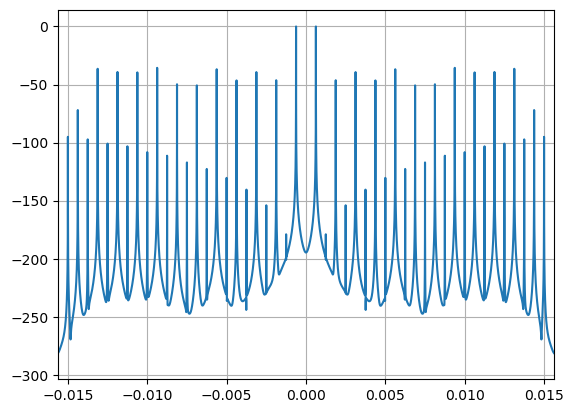

In [83]:
print(angle)
print(angle_1b)

plt.plot(freqs, xfft)
plt.grid()
plt.show();

plt.plot(freqs_1b, xfft_1b)
plt.xlim([np.min(freqs_1b)/len(LUT[0]), np.max(freqs_1b)/len(LUT[0])])
plt.grid()
plt.show();

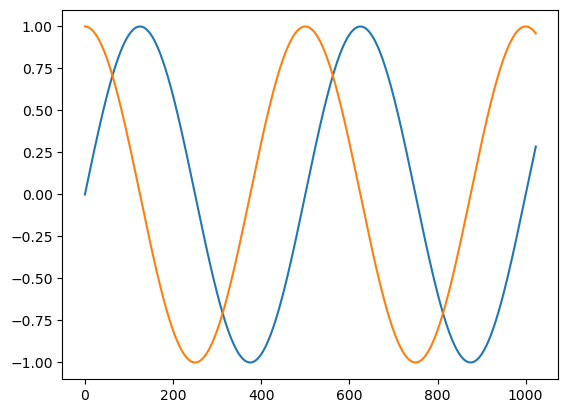

0.4978481069342052


In [15]:
N = 1024
n = np.arange(N)
F = 0.002
x1 = 1.0 * np.sin(2*np.pi*n*F)
x2 = 1.0 * np.sin(2*np.pi*n*F + np.pi/2)

plt.plot(x1)
plt.plot(x2)
plt.show();

x1fft = np.fft.fftshift(np.fft.fft(x1))
x1_angle = np.angle(x1fft)
x2fft = np.fft.fftshift(np.fft.fft(x2))
x2_angle = np.angle(x2fft)

Fbin = np.argmax(x2fft)

dTheta_ = x2_angle-x1_angle
dTheta = np.abs(dTheta_[Fbin] / np.pi)
print(dTheta)

In [16]:
N = 1024
n = np.arange(N)
F = 0.002

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

AdB = 140
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

Fpass = Fmax
Fstop = 1 - Fmax

I = 4
Fpass /= I
Fstop /= I

x = 1.0 * np.exp(1j*2*np.pi*F*n)

Fmax = 0.425


In [17]:
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, even_n = False, nPoints=N, Nmax=N)
polyFirCoeff = makePolyphase(firCoeff, I)

commonDelay = int((len(firCoeff) - 1) / 2 / I)
print(commonDelay)

x_real_delayed = signal.lfilter(polyFirCoeff[-2], 1.0, x.real)
x_imag_delayed = signal.lfilter(polyFirCoeff[-1], 1.0, x.imag)

29


In [18]:
x_real_delayed = x_real_delayed[commonDelay:]
x_real_delayed *= signal.windows.hamming(len(x_real_delayed), False)
x1fft = np.fft.fftshift(np.fft.fft(x_real_delayed))
x1_angle = np.angle(x1fft)[np.argmax(x1fft)]

x_real = x.real[:-commonDelay]
x_real *= signal.windows.hamming(len(x_real), False)
x2fft = np.fft.fftshift(np.fft.fft(x_real))
x2_angle = np.angle(x2fft)[np.argmax(x2fft)]

dTheta = x2_angle - x1_angle
dTheta /= np.pi
print(dTheta)
print(F)

x_imag_delayed = x_imag_delayed[commonDelay:]
x_imag_delayed *= signal.windows.hamming(len(x_imag_delayed), False)
x1fft = np.fft.fftshift(np.fft.fft(x_imag_delayed))
x1_angle = np.angle(x1fft)[np.argmax(x1fft)]

x_imag = x.imag[:-commonDelay]
x_imag *= signal.windows.hamming(len(x_imag), False)
x2fft = np.fft.fftshift(np.fft.fft(x_imag))
x2_angle = np.angle(x2fft)[np.argmax(x2fft)]

dTheta = x2_angle - x1_angle
dTheta /= np.pi
print(dTheta)
print(F/2)

0.020009116724767868
0.002
-0.0010008106801693815
0.001


In [19]:
firCoeff = remezlp(Fpass, Fstop, deltaPass, deltaStop, nPoints=N, Nmax=500)
polyFIR = makePolyphase(firCoeff, I)
commonDelay = int((len(firCoeff)-1) / (2*I))

x_real_delayed = signal.lfilter(polyFIR[-2], 1.0, x.real)[commonDelay:]
x_imag_delayed = signal.lfilter(polyFIR[-1], 1.0, x.imag)[commonDelay:]

x_real_delayed /= np.max(x_real_delayed)
x_imag_delayed /= np.max(x_imag_delayed)

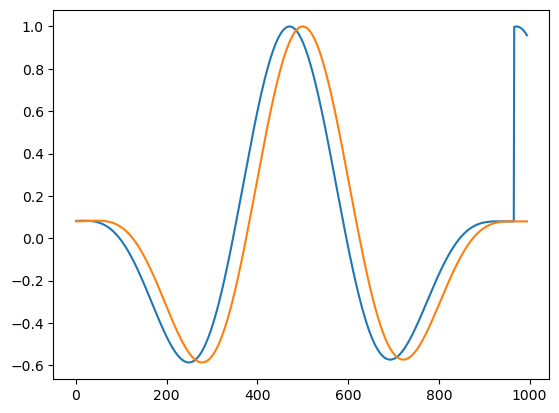

995 995
995 995


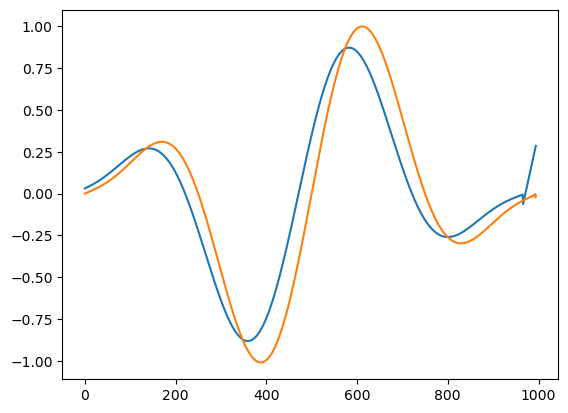

In [20]:
x_real = x.real[commonDelay:]
plt.plot(x_real)
plt.plot(x_real_delayed)
plt.show();

x_imag = x.imag[commonDelay:]
plt.plot(x_imag)
plt.plot(x_imag_delayed)

print(len(x_real), len(x_real_delayed))
print(len(x_imag), len(x_imag_delayed))

In [21]:
x1fft = np.fft.fftshift(np.fft.fft(x_imag))
x2fft = np.fft.fftshift(np.fft.fft(x_imag_delayed))

Fbin = np.argmax(np.abs(x1fft))
print(Fbin)

x1_angle = np.angle(x1fft)
x2_angle = np.angle(x2fft)
dTheta = x2_angle[Fbin] - x1_angle[Fbin]
# dTheta /= np.pi
print(dTheta)

495
0.37332946936404365


In [22]:
np.pi/2 * F

0.0031415926535897933